<a href="https://colab.research.google.com/github/itchyfeet-patient/Beautiful-Exploration/blob/master/Exploration_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration_8 프로젝트 : 네이버 영화리뷰 감성분석 도전하기 🎥 💟

이전 스텝까지는 영문 텍스트의 감정 분석을 진행해 보았습니다. 그렇다면 이번에는 한국어 텍스트의 감정 분석을 진행해 보면 어떨까요? **오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.**


## 라이브러리 버전을 확인해 봅니다

사용할 라이브러리 버전을 둘러봅시다.

In [ ]:
#!apt-get update
#!apt-get install g++ openjdk-8-jdk
#!pip install konlpy JPype1-py3
#!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
#!pip install --upgrade gensim

In [ ]:
#!pip install --upgrade keras==2.6.0 

In [ ]:
#!pip install --upgrade tensorflow==2.6.0 

konlpy를 설치해주고 tensorflow와 keras의버전을 확인 후 2.6.0 버전으로 downgrade 해줬습니다. (2.9.0일때만 해당)

In [ ]:
import pandas
import konlpy
import gensim
import tensorflow as tf
import keras

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)
print(tf.__version__)
print(keras.__version__)

1.3.5
0.6.0
4.2.0
2.8.2
2.8.0


설치되어있지 않던 패키지인 **KoNLPy(코엔엘파이라고 읽는다)** 는 한국어 정보처리를 위한 파이썬 패키지입니다.  
[참고 링크](https://datascienceschool.net/03%20machine%20learning/03.01.02%20KoNLPy%20%ED%95%9C%EA%B5%AD%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html)

## 1) 데이터 준비와 확인
---

ratings_train파일을 train_data로 불러오고 ratings_test파일을 test_data로 불러왔습니다.

In [ ]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/drive/MyDrive/dataset/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/dataset/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성
---


실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 `imdb.data_loader()` 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 `word_to_index` 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 `imdb.data_loader()`와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. `data_loader` 안에서는 다음을 수행해야 합니다.  
* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴


In [ ]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000

def load_data(train_data, test_data, num_words=num_words):
    # 데이터 중복제거
    train_data.drop_duplicates(subset=['document'],inplace=True)
    test_data.drop_duplicates(subset=['document'],inplace=True)

    # NaN 결측치 제거
    train_data = train_data.dropna(how = 'any')
    test_data = test_data.dropna(how = 'any')

    # 한국어 토크나이저로 토큰화, 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 형태소 추출 (토큰화)
        # 1) morphs : 형태소 추출 2) pos : 품사 태깅(Part-of-speech tagging) 3) nouns : 명사 추출
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        # stopwords가 포함되어있지 않은 word만 temp_X에서 출력
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    # 사전 word_to_index 구성

    words = np.concatenate(X_train).tolist() 
        # .tolist() : series 자료형을 리스트 형식으로 바꿔줌
        # train_token의 토큰화된 단어들을 모아 합쳐줍니다. 그리고 리스트 형식으로 바꿔줌
    counter = Counter(words) # words를 셀거야
    # collection 모듈의 counter 클래스 : 리스트 원소들의 개수를 알 고 싶을 때 사용
    counter = counter.most_common(10000-4) # 가장 많이 나타난 10000-4개를 출력한다.
    # counter는 dictionary 형태로 출력
    


    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    # counter에 key값 value값이 딕셔너리
    # vocab변수에 공백네개 + counter에 저장된 key값과 value를 가져와서 key값을 붙임 
    # (_는 counter가 딕셔너리로 키값과 밸류값으로 이뤄져 있으므로 두개의 변수가 필요해 그냥 쓴듯? 우리가 원하는 건 key값이니까.)
    word_to_index = {word:index for index, word in enumerate(vocab)} 
    # enumerate가 (index, 리스트 원소) 꼴로 함께 가져오는 함수
    # vocab 가져와서 index, word 갖고와서 반대로 word:index꼴로 만듬

    # 함수화
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]



    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    # X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

---
함수 안에서 코딩을 하다 보니 이해가 잘 안돼서 직접 출력해보며 코딩했습니다.  
아래 사진을 보면  
* 형태소 변환된(토큰화된) X_train , X_test 출력  
* counter의 결과물로 나온 딕셔너리 (원소 개수 세서 딕셔너리형태로 나온)
* counter 출력의 key값을 PAD, BOS, UNK, UNUSED 추가해서 모조리 한 리스트로 합친vocab의 출력
* X_train의 출력값(토큰화된)을 한 리스트로 합쳐 리스트형태로 바꿔준(tolist) 출력 words

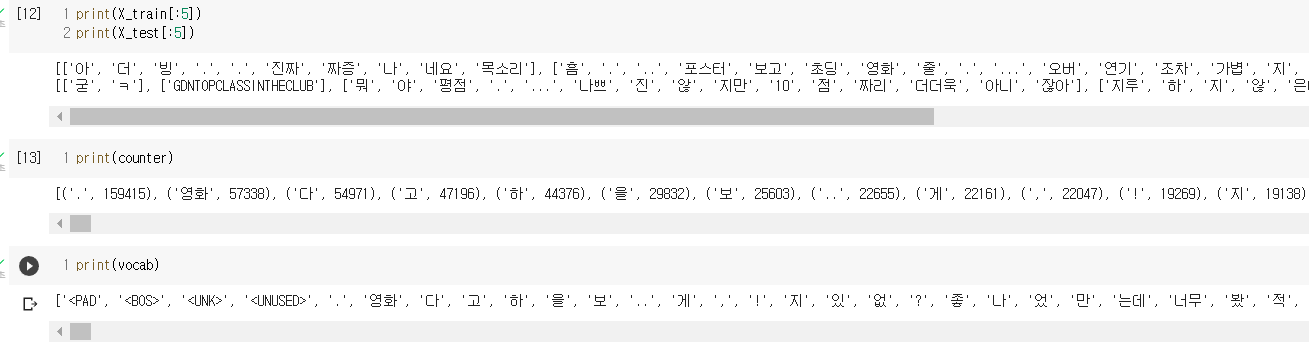

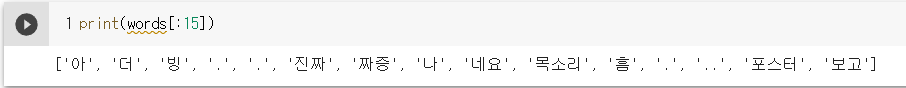

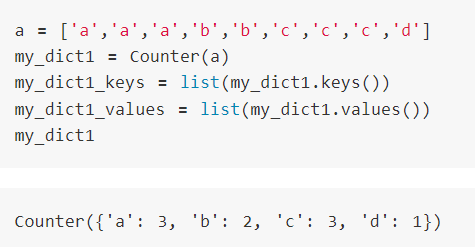

counter함수는 해당 리스트의 원소 개수와, 원소를 key:value  딕셔너리 형태로 출력해줌.

konlpy에는 여러가지 형태소 분석 , 태깅 라이브러리를 파이썬에서 쉽게 활용할 수 있게 모아 놓았습니다.  
그 중 우리가 사용할 것은 `Mecab` 메카브인데요.  
일본어용 형태소 분석기를 한국어를 사용할 수 있도록 수정한 것입니다.  
[토큰화에 대한 좋은 글](https://wikidocs.net/21698)

---
index_to_word도 만들어줍니다.  
다시 변환해줘야 우리가 알아볼 수 있으니까요

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
print(index_to_word[1])
print(word_to_index['.'])
print(index_to_word[4])

<BOS>
4
.


정상적으로 decode 되는 지 확인


In [ ]:
print(get_decoded_sentence(X_train[1], index_to_word))
print('라벨 ',y_train[1])

. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
라벨  1


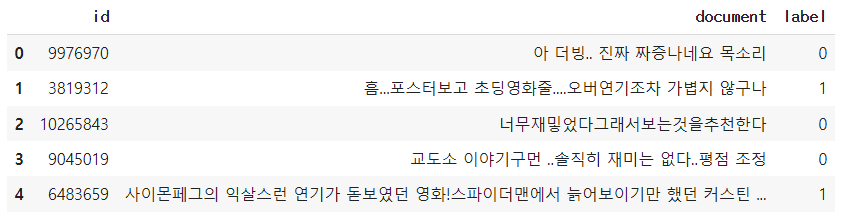

## 3) 모델 구성을 위한 데이터 분석 및 가공
---
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [ ]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


maxlen이 41이 됩니다.

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4) 모델 구성 및 validation set 구성
---

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.


In [ ]:
# 기본형 (RNN)
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_1.add(tf.keras.layers.Dense(8, activation='relu'))
model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 16)          160000    
                                                                 
 lstm_4 (LSTM)               (None, 8)                 800       
                                                                 
 dense_16 (Dense)            (None, 8)                 72        
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 1-D CNN
# 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 7단어 이내에서
# 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식
# 병렬처리가 효율적이라 RNN보다 학습속도도 훨씬 빠르게 진행됨.
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.MaxPooling1D(5))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.GlobalMaxPooling1D())
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 16)          160000    
                                                                 
 conv1d_4 (Conv1D)           (None, None, 16)          1808      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_5 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 8)               

In [ ]:
# GlobalMaxPooling1D 레이어 한개
# 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로
# 문장의 긍정/부정을 평가하는 방식
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 16)          160000    
                                                                 
 lstm_5 (LSTM)               (None, 8)                 800       
                                                                 
 dense_20 (Dense)            (None, 8)                 72        
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


[모델관련 참고링크](https://wikidocs.net/80437)

## 5) 모델 훈련 개시

In [ ]:
print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


Total Data 195,339  
Train Data 146,182 약 74%  
Test Data 49,157 약 25%

Validation Set Split  
보통 train data : test data = 7:3 으로 합니다. 그러나 이것은 절대적인 비율이 아니라고 합니다. 백만개 이상의 데이터셋인 경우에는 train data의 비율을 많이 높이는 게 좋다고 합니다. 우리는 십만개 정도고 이미 약 7:3의 비율로 분리되어 있으므로 테스트 데이터의 절반정도를 Validation Data로 분리해보겠습니다.  
그러면  
Total Data 195,339   
Train Data 121,604 약 62.25%  
Test Data 49,157 약 25%  
Validation Data 24,578 약 12.5%

[Validation Dataset 개수 참고](https://brunch.co.kr/@coolmindory/31)


In [ ]:
# validation set 24,578건 분리
X_val = X_train[:24578]   
y_val = y_train[:24578]

# validation set을 제외한 나머지 121604건
partial_X_train = X_train[24578:]  
partial_y_train = y_train[24578:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(121604, 41)
(121604,)


partial train data의 개수를 보니 121,604로 우리가 의도한 대로 나왔습니다.

모델 학습을 시작해 보겠습니다.

### model_1 : RNN 모델

In [ ]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_1 = model_1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
238/238 [==============================] - 4s 10ms/step - loss: 0.5299 - accuracy: 0.7608 - val_loss: 0.3907 - val_accuracy: 0.8388
Epoch 2/20
238/238 [==============================] - 2s 7ms/step - loss: 0.3520 - accuracy: 0.8529 - val_loss: 0.3503 - val_accuracy: 0.8472
Epoch 3/20
238/238 [==============================] - 2s 7ms/step - loss: 0.3210 - accuracy: 0.8669 - val_loss: 0.3461 - val_accuracy: 0.8500
Epoch 4/20
238/238 [==============================] - 2s 7ms/step - loss: 0.3069 - accuracy: 0.8736 - val_loss: 0.3508 - val_accuracy: 0.8498
Epoch 5/20
238/238 [==============================] - 2s 9ms/step - loss: 0.2962 - accuracy: 0.8782 - val_loss: 0.3438 - val_accuracy: 0.8528
Epoch 6/20
238/238 [==============================] - 2s 8ms/step - loss: 0.2857 - accuracy: 0.8828 - val_loss: 0.3477 - val_accuracy: 0.8516
Epoch 7/20
238/238 [==============================] - 2s 7ms/step - loss: 0.2758 - accuracy: 0.8869 - val_loss: 0.3493 - val_accuracy: 0.8528
Epoch

학습이 끝난 모델을 테스트셋으로 평가해 봅니다.

In [ ]:
results = model_1.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.5151 - accuracy: 0.8410 - 4s/epoch - 3ms/step
[0.5151333808898926, 0.8409585356712341]


### model_2 : 1 - D CNN 모델

In [ ]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_2 = model_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
238/238 [==============================] - 2s 7ms/step - loss: 0.4914 - accuracy: 0.7461 - val_loss: 0.3520 - val_accuracy: 0.8473
Epoch 2/20
238/238 [==============================] - 1s 6ms/step - loss: 0.3232 - accuracy: 0.8626 - val_loss: 0.3390 - val_accuracy: 0.8537
Epoch 3/20
238/238 [==============================] - 1s 6ms/step - loss: 0.2839 - accuracy: 0.8831 - val_loss: 0.3378 - val_accuracy: 0.8544
Epoch 4/20
238/238 [==============================] - 1s 6ms/step - loss: 0.2490 - accuracy: 0.9001 - val_loss: 0.3474 - val_accuracy: 0.8538
Epoch 5/20
238/238 [==============================] - 1s 6ms/step - loss: 0.2114 - accuracy: 0.9181 - val_loss: 0.3708 - val_accuracy: 0.8495
Epoch 6/20
238/238 [==============================] - 1s 6ms/step - loss: 0.1752 - accuracy: 0.9359 - val_loss: 0.4009 - val_accuracy: 0.8448
Epoch 7/20
238/238 [==============================] - 1s 6ms/step - loss: 0.1424 - accuracy: 0.9505 - val_loss: 0.4434 - val_accuracy: 0.8403
Epoch 

학습이 끝난 모델을 테스트셋으로 평가해 봅니다.

In [ ]:
results = model_2.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.0236 - accuracy: 0.8157 - 3s/epoch - 2ms/step
[1.0235824584960938, 0.8156722187995911]


### model_3 : GlobalMaxPooling 모델

In [ ]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_3 = model_3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
238/238 [==============================] - 4s 9ms/step - loss: 0.4848 - accuracy: 0.7902 - val_loss: 0.3651 - val_accuracy: 0.8408
Epoch 2/20
238/238 [==============================] - 2s 7ms/step - loss: 0.3405 - accuracy: 0.8571 - val_loss: 0.3508 - val_accuracy: 0.8479
Epoch 3/20
238/238 [==============================] - 2s 7ms/step - loss: 0.3190 - accuracy: 0.8677 - val_loss: 0.3480 - val_accuracy: 0.8491
Epoch 4/20
238/238 [==============================] - 2s 7ms/step - loss: 0.3086 - accuracy: 0.8721 - val_loss: 0.3502 - val_accuracy: 0.8496
Epoch 5/20
238/238 [==============================] - 2s 7ms/step - loss: 0.3006 - accuracy: 0.8758 - val_loss: 0.3514 - val_accuracy: 0.8493
Epoch 6/20
238/238 [==============================] - 2s 7ms/step - loss: 0.2942 - accuracy: 0.8787 - val_loss: 0.3522 - val_accuracy: 0.8488
Epoch 7/20
238/238 [==============================] - 2s 7ms/step - loss: 0.2875 - accuracy: 0.8811 - val_loss: 0.3542 - val_accuracy: 0.8482
Epoch 

학습이 끝난 모델을 테스트셋으로 평가해 봅니다.

In [ ]:
results = model_3.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4348 - accuracy: 0.8406 - 4s/epoch - 3ms/step
[0.43482136726379395, 0.8405720591545105]


## 6) Loss, Accuracy 그래프 시각화

### model_1 : RNN 모델

In [ ]:
history_dict = history_1.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


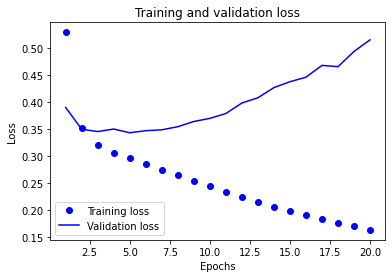

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있습니다. validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더 이상의 트레이닝은 무의미해지게 마련입니다.



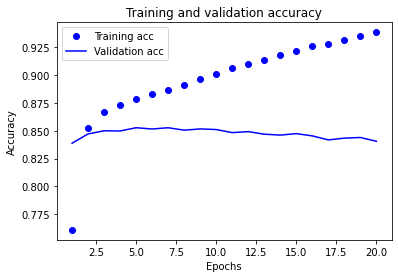

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### model_2 : 1 - D CNN 모델

In [ ]:
history_dict = history_2.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


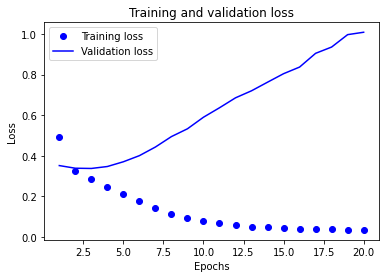

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있습니다. validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더 이상의 트레이닝은 무의미해지게 마련입니다.



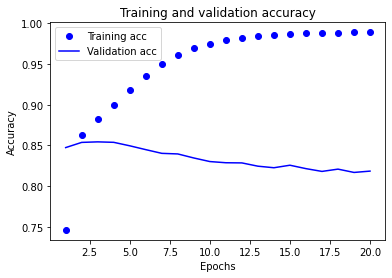

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### model_3 : GlobalMaxPooling 모델

In [ ]:
history_dict = history_3.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


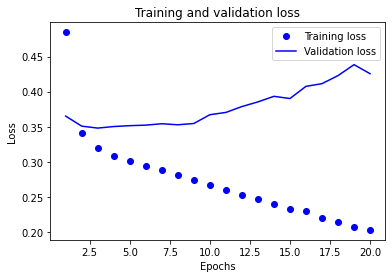

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있습니다. validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더 이상의 트레이닝은 무의미해지게 마련입니다.



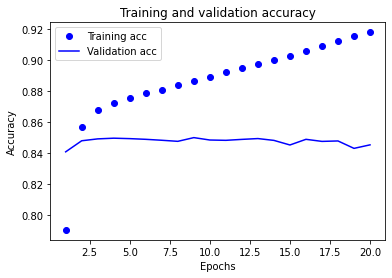

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

In [ ]:
embedding_layer_1 = model_1.layers[0]
weights = embedding_layer_1.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/dataset/sentiment_classification/data/word2vec_1.txt'

f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.



In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_1 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors_1['재미']
vector

array([ 0.20623413, -0.05056569,  0.0696202 , -0.07076243,  0.03613318,
        0.03686428, -0.01527788, -0.05864872,  0.08456145, -0.02728013,
        0.09132414, -0.05887605,  0.13510545, -0.00567078,  0.0703567 ,
       -0.10824519], dtype=float32)

위와 같이 얻은 워드 벡터를 가지고 재미있는 실험을 해볼 수 있습니다. 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하는 방법 중에, 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법이 있습니다. gensim을 사용하면 아래와 같이 해볼 수 있습니다.



In [ ]:
word_vectors_1.similar_by_word("재미")

[('풀', 0.9240810871124268),
 ('가져', 0.8147364258766174),
 ('가을', 0.7940587401390076),
 ('흥미', 0.7939713597297668),
 ('교훈', 0.7938187122344971),
 ('여성', 0.7810221314430237),
 ('다가오', 0.7716469764709473),
 ('명배우', 0.7642228603363037),
 ('만나', 0.7636395692825317),
 ('^^;;', 0.7631682753562927)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선


* 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
* 한국어 Word2Vec을 활용할 때는 `load_word2vec_format()` 형태가 아닌 `load()` 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 `.wv`를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. [참고 링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models), [참고 링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = '/content/drive/MyDrive/dataset/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']
vector  

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [ ]:
word_vectors.wv.most_similar("재미")


[('묘미', 0.6163142919540405),
 ('취미', 0.6034970283508301),
 ('흥미', 0.5939850211143494),
 ('유머', 0.5888698101043701),
 ('보람', 0.5689517259597778),
 ('즐거움', 0.5631207823753357),
 ('개그', 0.5552946329116821),
 ('이야기', 0.5536993741989136),
 ('연애', 0.552293598651886),
 ('열의', 0.546456515789032)]

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in vector:
        embedding_matrix[i] = vector[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


### model_1 : RNN 모델


In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model_1.add(tf.keras.layers.Dropout(0.3))
model_1.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)

model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model_1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 41, 300)           3000000   
                                                                 
 dropout_6 (Dropout)         (None, 41, 300)           0         
                                                                 
 lstm_6 (LSTM)               (None, 128)               219648    
                                                                 
 dense_22 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,219,777
Trainable params: 3,219,777
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습의 진행
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model_1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1, callbacks = [es])

Epoch 1/20
238/238 [==============================] - 6s 17ms/step - loss: 0.5342 - accuracy: 0.7185 - val_loss: 0.3825 - val_accuracy: 0.8307
Epoch 2/20
238/238 [==============================] - 4s 15ms/step - loss: 0.3863 - accuracy: 0.8284 - val_loss: 0.3458 - val_accuracy: 0.8475
Epoch 3/20
238/238 [==============================] - 4s 15ms/step - loss: 0.3487 - accuracy: 0.8478 - val_loss: 0.3345 - val_accuracy: 0.8547
Epoch 4/20
238/238 [==============================] - 4s 15ms/step - loss: 0.3263 - accuracy: 0.8593 - val_loss: 0.3271 - val_accuracy: 0.8567
Epoch 5/20
238/238 [==============================] - 4s 15ms/step - loss: 0.3073 - accuracy: 0.8684 - val_loss: 0.3221 - val_accuracy: 0.8610
Epoch 6/20
238/238 [==============================] - 4s 15ms/step - loss: 0.2952 - accuracy: 0.8751 - val_loss: 0.3154 - val_accuracy: 0.8628
Epoch 7/20
238/238 [==============================] - 4s 15ms/step - loss: 0.2832 - accuracy: 0.8809 - val_loss: 0.3240 - val_accuracy: 0.8629

### model_2 : 1 - D CNN 모델

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
                                 
model_2.add(tf.keras.layers.Dropout(0.3))
model_2.add(tf.keras.layers.Conv1D(256, 3,padding='valid', activation='relu'))
model_2.add(tf.keras.layers.GlobalMaxPooling1D())
model_2.add(tf.keras.layers.Dense(128, activation='relu'))
model_2.add(tf.keras.layers.Dropout(0.3))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 41, 300)           3000000   
                                                                 
 dropout_7 (Dropout)         (None, 41, 300)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 39, 256)           230656    
                                                                 
 global_max_pooling1d_6 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                     

In [ ]:
# 학습의 진행
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=100  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 



history = model_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1, callbacks=[es])

Epoch 1/100
238/238 [==============================] - 5s 16ms/step - loss: 0.6960 - accuracy: 0.5556 - val_loss: 0.5933 - val_accuracy: 0.6580
Epoch 2/100
238/238 [==============================] - 4s 16ms/step - loss: 0.4613 - accuracy: 0.7817 - val_loss: 0.3750 - val_accuracy: 0.8337
Epoch 3/100
238/238 [==============================] - 4s 15ms/step - loss: 0.3836 - accuracy: 0.8322 - val_loss: 0.3549 - val_accuracy: 0.8437
Epoch 4/100
238/238 [==============================] - 4s 15ms/step - loss: 0.3567 - accuracy: 0.8459 - val_loss: 0.3449 - val_accuracy: 0.8506
Epoch 5/100
238/238 [==============================] - 4s 16ms/step - loss: 0.3384 - accuracy: 0.8554 - val_loss: 0.3369 - val_accuracy: 0.8524
Epoch 6/100
238/238 [==============================] - 4s 16ms/step - loss: 0.3230 - accuracy: 0.8632 - val_loss: 0.3293 - val_accuracy: 0.8569
Epoch 7/100
238/238 [==============================] - 4s 16ms/step - loss: 0.3116 - accuracy: 0.8691 - val_loss: 0.3259 - val_accuracy:

### model_3 : GlobalMaxPooling 모델

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(64, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 41, 300)           3000000   
                                                                 
 global_max_pooling1d_7 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_25 (Dense)            (None, 64)                19264     
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,019,329
Trainable params: 3,019,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습의 진행

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=100  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 



history = model_3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1, callbacks=[es])

Epoch 1/100
238/238 [==============================] - 3s 8ms/step - loss: 0.5678 - accuracy: 0.7306 - val_loss: 0.4100 - val_accuracy: 0.8219
Epoch 2/100
238/238 [==============================] - 2s 7ms/step - loss: 0.3629 - accuracy: 0.8431 - val_loss: 0.3499 - val_accuracy: 0.8456
Epoch 3/100
238/238 [==============================] - 2s 7ms/step - loss: 0.3119 - accuracy: 0.8680 - val_loss: 0.3382 - val_accuracy: 0.8512
Epoch 4/100
238/238 [==============================] - 2s 7ms/step - loss: 0.2790 - accuracy: 0.8855 - val_loss: 0.3376 - val_accuracy: 0.8526
Epoch 5/100
238/238 [==============================] - 2s 7ms/step - loss: 0.2520 - accuracy: 0.8990 - val_loss: 0.3527 - val_accuracy: 0.8470
Epoch 6/100
238/238 [==============================] - 2s 7ms/step - loss: 0.2282 - accuracy: 0.9100 - val_loss: 0.3659 - val_accuracy: 0.8445
Epoch 7/100
238/238 [==============================] - 2s 7ms/step - loss: 0.2029 - accuracy: 0.9223 - val_loss: 0.3807 - val_accuracy: 0.8467

In [ ]:
# 테스트셋을 통한 모델 평가

results_1 = model_1.evaluate(X_test,  y_test, verbose=2)
results_2 = model_2.evaluate(X_test,  y_test, verbose=2)
results_3 = model_3.evaluate(X_test,  y_test, verbose=2)


print(results_1, results_2, results_3)

1537/1537 - 4s - loss: 0.3245 - accuracy: 0.8635 - 4s/epoch - 3ms/step
1537/1537 - 3s - loss: 0.3365 - accuracy: 0.8589 - 3s/epoch - 2ms/step
1537/1537 - 3s - loss: 0.3934 - accuracy: 0.8418 - 3s/epoch - 2ms/step
[0.3244946599006653, 0.8635392785072327] [0.3364717960357666, 0.8588603734970093] [0.39343225955963135, 0.8417519330978394]


In [ ]:
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

def sentiment_predict(new_sentence):    
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence) # 정규표현식을 이용한 한국어 외 문자 제거
    new_sentence = tokenizer.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거

    new_sentence = get_encoded_sentences(new_sentence, word_to_index) # 정수 인코딩

   # for i in range(len(new_sentence)):
   #    new_sentence[i] = word_to_index[new_sentence[i]]
   # 위 식으로 정수인코딩 해줬다가 pad_sequence에서 오류가 나서 힘들었다..

    pad_new = pad_sequences(new_sentence,  value=word_to_index["<PAD>"],  padding='pre', maxlen = maxlen)
    # 패딩
    score = model_2.predict(pad_new)
    score = float(sum(score) /len(score))
    # 패딩 결과를 모델에 넣고 예측결과를 얻으니 각각의 단어에 따른 긍정/ 부정확률이 나왔다. 
    # 어떻게 처리할지 고민하다가 그냥 평균을 내버림..

    if score > 0.5:
        print(f"{score * 100: 0.2f}% 확률로 긍정 리뷰입니다.")
    else:
        print(f"{(1 - score) * 100: 0.2f}% 확률로 부정 리뷰입니다.")

In [ ]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

 72.35% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('아 개노잼...')

 56.78% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('돈 아깝다 ..')

 69.13% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('대박.. 꼭 보세요.. 소름돋음')

 69.80% 확률로 긍정 리뷰입니다.


나름 잘 나오는 것을 확인할 수 있습니다. 


---

## 🎯 평가 루브릭
| **평가문항** | **상세기준** | **학습결과** |
|:---:|---|:---:|
| 1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. | 3가지 이상의 모델이 성공적으로 시도됨 | O |
| 2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. | gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함 | O |
| 3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다. | 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함 | Accuracy : 86.35% |

## ✍ 회고

* RNN 모델 dense층 하나 줄이고 LSTM state 벡터의 차원수 늘리고 dropout해주니 86%가 넘었다. 층을 하나 줄여서일까? 정확도는 상승했으나 예측 모델의 결과에서 긍정 리뷰를 부정으로 인식하는 경우가 있었다. 과적합?

* 며칠간 이 문서 안열다가 제출할 때 돼서 열었는데.. 

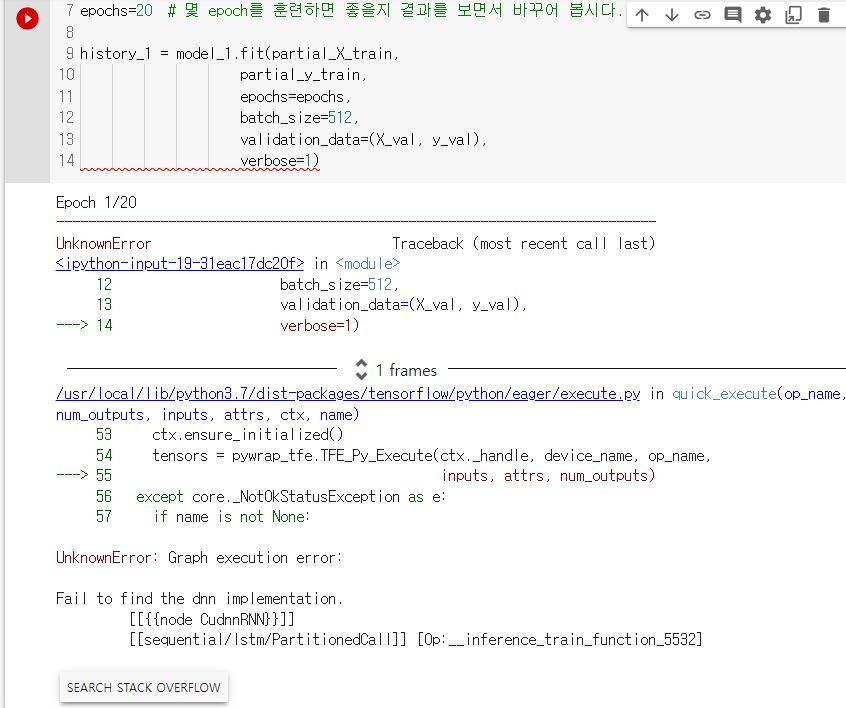

`UnknownError: Graph execution error:%0A%0AFail to find the dnn implementation.%0A%09 [[{{node CudnnRNN}}]]%0A%09 [[sequential_7/lstm_5/PartitionedCall]] [Op:__inference_train_function_17377]`   
멀쩡히 잘 돌아가던 코드가 요상한 에러를 뱉음. 구글링 해보니 tensorflow랑 keras 버전문제인듯? 왠지 ex.9 할때 tensorflow랑 keras 버전 바꾼게 문제였던듯? 근데 오류났을 때 버전 체크해보니 2.9.0 이었는데 ㅇㅅㅇ... 암튼 LMS 버전(2.6.0)이랑 같게 해주니 멀쩡히 돌아갔다. 진짜.. 괜한데 힘빼는 재주가 있다 ㅎㅎ  
+추가) 런타임 초기화 된 상태에서 다시 돌리니 각각 2.8.2 2.8.0 버전이었고 오류없이 잘 돌아갔다. 2.9.0에서 발생하는 오류인 듯~

* **(긴글주의) 시간 많으신분들만 읽으세용**  
마지막 sentiment_predict 함수에서 엄청난 시간을 쏟았다. 저번에 작사가 만들기 Exploration에서는 마지막에 작사를 직접 해보고 얼마나 잘 만들어졌는지 평가를 했는데 이번에는 그런 단계가 없어서 뭘 위해서 이 프로젝트를 했는지 목표가 모호해졌고 잘 만들어졌는지도 모르겠더라. wv을 사용해서 어떻게 해 볼수 없는지 찾다가  [여기](https://wikidocs.net/80783)서 리뷰예측 함수를 찾았다. (정말감사합니다요)   
그런데 예측을 하려면 예측 대상인 문장 전처리를 동일하게 해줘야 하는데 당연하게도 이분이 하신 전처리 방법은 달랐다. 그래서 한 줄 한 줄 오류를 뱉었고   
첫번째 난관은 정수화였다. 이분은 `texts_to_sequences`라는 tensorflow 텍스트 전처리 메소드를 사용하셨는데 우리는 `word_to_index`를 사용해서 `get_encoded_sentence(sentences, word_to_index)` 와 같이 문장을 넣으면 단어 인덱스 리스트 벡터로 변환해 주는 함수를 사용했다. 사실 `texts_to_sequences` 를 사용해 본 적이 없어서 결과값이 어떻게 반환되는 지는 잘 모르겠으나, 아무튼 안됐다. 처음에는 `word_to_index`를 사용해서 계속 오류가 났는데, 생각해보니 토큰화 되면 리스트에 ['영화', '개노잼'] 처럼 여러 요소가 담기는데 한 단어씩 인덱스로 바꾸는 `word_to_index`를 왜 쓰려고 한건지 이상하다. `get_encoded_sentence`를 사용하니 잘 됐다.  
두번째 난관은 `pad_sequences`였다. [5, 12] 같은 꼴로 pad_sequences에 들어가면 안된다... [[5,12],[2,23]] 이런꼴로 들어가야 한다.(당연함.. 패딩 왜하는데!!!) 공식문서 찾아보고 알았음. 그래서!! `get_encoded_sentence`로 정수화 시켰을 때 [[5,12],[2,23]] 이런꼴로 나오니 잘못된 건줄 알고   
`for i in range(len(new_sentence)):`     
`new_sentence[i] = word_to_index[new_sentence[i]]`  
로 [5, 12] 이렇게 바꿔줬다. 오류가 생겨서 공식문서 찾아보고 다시 바꿈 ㅎㅎ  
세번째는 난관은 아니고 패딩 결과를 모델에 넣고 예측결과를 얻으니 각각의 단어에 따른 긍정/ 부정확률이 나왔다. [44.2345, 75.5744, 34.6544] 같이.. 이걸 어떻게 처리할지 고민하다가 그냥 평균을 내버렸다. 부정적일 확률이 높은 단어들이 모이면 어차피 부정적인 리뷰일 확률이 높은거니까? 

* 너무 아쉬운게 사실 여기서 모델 설계하는것도 비중이 크다고 생각하는데 다른 거 하느라 1-D CNN & RNN MIXUP , FFN(FeedForward Network)레이어만으로 이루어진 모델, Transformer 레이어 와 같은 모델을 설계해볼 수 없었다. 뒤에 또 나오지 않을까..? ㅎㅎ..ㅎㅎ..

* EarlyStopping를 처음 써봤는데 너무 편하고 좋았다. 다음에도 써야지 ModelCheckpoint는 어떻게 쓰는지 모르겠다. 수련이 필요

* 이해할 내용이 많아서 조금 힘든 Ex였다......... 그렇지만 궁금한 부분을 더 파보지 않았더라면 내가 이만큼 이해할 수 있었을까? 그냥 모델 슥 돌리고 정확도 넘었네 하고 말았겠지? 자연어 처리 힘든데 나쁘지 않은것 같기도 하고 아직 긴가민가하다.

---

## 참고문헌
* def sentiment_predict : 리뷰 예측 결과 코드 참고 [링크](https://wikidocs.net/94600)
* EarlyStopping, CNN 모델 : [링크](https://wikidocs.net/80783)
